In [21]:
!pip install gdown  # Ensure gdown is installed

In [22]:
import gdown

# Replace FILE_ID with your actual file ID
file_id = "1ACqNSMehbd1le-gbjsxxDNELFUZ5IONI"
output_file = "Hard_Hat_Datasets.zip"

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1ACqNSMehbd1le-gbjsxxDNELFUZ5IONI
From (redirected): https://drive.google.com/uc?id=1ACqNSMehbd1le-gbjsxxDNELFUZ5IONI&confirm=t&uuid=ef9ca719-5f51-4c5d-bcd0-c9ecd745e034
To: /content/Hard_Hat_Datasets.zip
100%|██████████| 37.4M/37.4M [00:00<00:00, 179MB/s]


'Hard_Hat_Datasets.zip'

In [23]:
import zipfile
z = zipfile.ZipFile('/content/Hard_Hat_Datasets.zip')
z.extractall()

## **Importing libraries**

In [2]:
import torch
import torchvision
import cv2
import os
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils
from torchvision.models.detection import SSD300_VGG16_Weights

## **Removing annotation file with size zero**

In [ ]:
import os
from PIL import Image

annotation_dir = "Hard_Hat_Datasets/train/labels"
images_dir = "Hard_Hat_Datasets/train/images"

annotations = os.listdir(annotation_dir)

for annotation in annotations:
    annotation_file = os.path.join(annotation_dir, annotation)
    image_file_name = annotation[:-4] + '.jpg'

    img = Image.open(os.path.join(images_dir, image_file_name))
    width, height = img.size

    with open(annotation_file, "r") as f:
        for line in f:
            data = line.strip().split()
            class_index = int(data[0])  # Class index
            x_center = float(data[1]) * width
            y_center = float(data[2]) * height
            box_width = float(data[3]) * width
            box_height = float(data[4]) * height

            # Convert to absolute coordinates [xmin, ymin, xmax, ymax]
            xmin = x_center - box_width / 2
            ymin = y_center - box_height / 2
            xmax = x_center + box_width / 2
            ymax = y_center + box_height / 2



Before : 1000
After : 1000


## **Create customdataset class**

In [26]:
class CustomDataset():
    def __init__(self, image_dir, annotations, annotations_dir, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.annotations_dir = annotations_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Get annotation file name
        annotation = self.annotations[idx]
        # Get image path
        img_path = os.path.join(self.image_dir, annotation[:-4] + '.jpg')

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image {img_path} not found.")

        # Convert image channels
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get image dimensions
        height, width, _ = image.shape

        # Parse the annotation file
        annotation_file = os.path.join(self.annotations_dir, annotation)
        boxes = []
        labels = []

        # Open annotation file
        with open(annotation_file, "r") as f:
            for line in f:
                # Split data
                data = line.strip().split()
                class_index = int(data[0])  # Class index
                x_center = float(data[1]) * width
                y_center = float(data[2]) * height
                box_width = float(data[3]) * width
                box_height = float(data[4]) * height

                # Convert to absolute coordinates [xmin, ymin, xmax, ymax]
                xmin = x_center - box_width / 2
                ymin = y_center - box_height / 2
                xmax = x_center + box_width / 2
                ymax = y_center + box_height / 2

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(int(class_index + 1))

        # Convert to PyTorch tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Create target dictionary
        target = {"boxes": boxes, "labels": labels}

        return image, target



## **Load Pretrained Model and Modify for Custom Classes**

In [3]:

def create_model(num_classes=2, size=300):
    model = torchvision.models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.COCO_V1)

    in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
    num_anchors = model.anchor_generator.num_anchors_per_location()

    # Replace the classification head for 1 class (pothole) + background
    model.head.classification_head = SSDClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes
    )

    # Adjust transform sizes
    model.transform.min_size = (size,)
    model.transform.max_size = size

    return model

model = create_model(num_classes=4, size=640)
print(model)


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [28]:
print(model)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

## **Creating the Dataloader**

In [29]:
# Step 4: Dataset and DataLoader

## TRAIN DATALOADER
train_image_dir = "Hard_Hat_Datasets/train/images"
train_annotation_dir = "Hard_Hat_Datasets/train/labels"
train_annotations = os.listdir(train_annotation_dir)

train_dataset = CustomDataset(train_image_dir, train_annotations, train_annotation_dir, transform=transforms.ToTensor())
train_data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


In [30]:
print(len(train_data_loader))

250


## **Setting LR OPTIM**

In [31]:
# Step 5: Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 50


# Epoch 1, LR: 0.001000
# Epoch 2, LR: 0.001000
# Epoch 3, LR: 0.001000
# Epoch 4, LR: 0.001 * 0.1 ==   0.000100
# Epoch 5, LR: 0.000100
# Epoch 6, LR: 0.000100
# Epoch 7, LR: 0.0001 * 0.1 == 0.000010

## **Checking Dataloader**

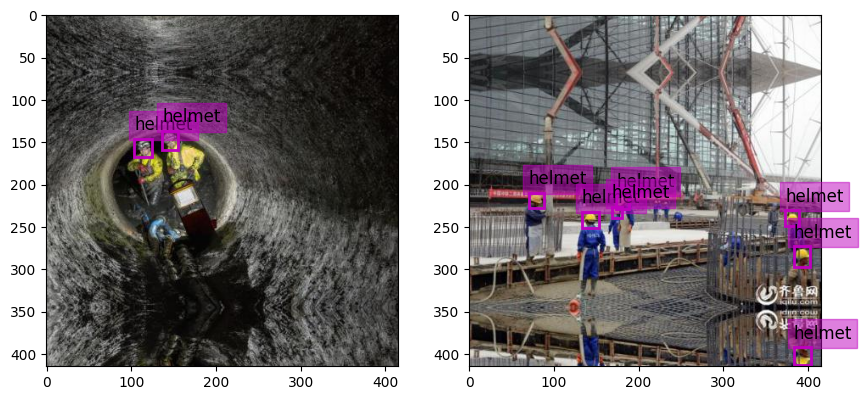

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.ravel()

# Get a batch of images and targets from the data loader
data_loader_iter = iter(train_data_loader)
images, targets = next(data_loader_iter)


class_names = ['bg', 'head', 'helmet', 'person']
color_sample = ['c','m','y']

# Plot the images with bounding boxes
for idx in range(2):
    image = images[idx].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C) for visualization
    target = targets[idx]
    boxes = target["boxes"].numpy()
    labels = target["labels"].numpy()

    ax[idx].imshow(image)

    # Add bounding boxes to the image
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle(
            (xmin, ymin),
            width,
            height,
            linewidth=2,
            edgecolor=color_sample[label-1],
            facecolor="none",
        )
        ax[idx].add_patch(rect)
        ax[idx].text(
            xmin,
            ymin - 10,
            f"{class_names[label]}",
            color="k",
            fontsize=12,
            bbox=dict(facecolor=color_sample[label-1], alpha=0.5, edgecolor=color_sample[label-1]),
        )

# Display the image with bounding boxes
plt.show()

In [33]:
# Step 6: Training Loop

for epoch in range(num_epochs):

    print(f'Starting the trainig of Epoch_{epoch+1}.....')
    print('Training...')

    model.train()
    train_running_loss = 0

    print(f'Epoch {epoch+1}/{num_epochs} training')


    for images, targets in train_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        # loss_classifier → Measures how well the model classifies objects into correct categories.
        # loss_box_reg → Evaluates how accurately the predicted bounding boxes match the ground truth.
        # loss_objectness → Checks how confident the model is in detecting objects versus background.
        # loss_rpn_box_reg → Assesses how well the Region Proposal Network (RPN) refines anchor boxes to better fit objects.

        # Backward pass
        optimizer.zero_grad() ## converting gradient value to zero for per batch
        losses.backward() ## compute the gradient
        optimizer.step() ## update the weights

        train_running_loss += losses.item()

    scheduler.step()
    print(f"Train_Loss: {train_running_loss/len(train_dataset):.4f}")
    print('\n')

Starting the trainig of Epoch_1.....
Training...
Epoch 1/50 training
Train_Loss: 1.0020


Starting the trainig of Epoch_2.....
Training...
Epoch 2/50 training
Train_Loss: 0.6765


Starting the trainig of Epoch_3.....
Training...
Epoch 3/50 training
Train_Loss: 0.5688


Starting the trainig of Epoch_4.....
Training...
Epoch 4/50 training
Train_Loss: 0.4665


Starting the trainig of Epoch_5.....
Training...
Epoch 5/50 training
Train_Loss: 0.4483


Starting the trainig of Epoch_6.....
Training...
Epoch 6/50 training
Train_Loss: 0.4366


Starting the trainig of Epoch_7.....
Training...
Epoch 7/50 training
Train_Loss: 0.4227


Starting the trainig of Epoch_8.....
Training...
Epoch 8/50 training
Train_Loss: 0.4166


Starting the trainig of Epoch_9.....
Training...
Epoch 9/50 training
Train_Loss: 0.4179


Starting the trainig of Epoch_10.....
Training...
Epoch 10/50 training
Train_Loss: 0.4170


Starting the trainig of Epoch_11.....
Training...
Epoch 11/50 training
Train_Loss: 0.4149


Starti

In [34]:
# Step 7: Save Trained Model
torch.save(model.state_dict(), "faster_rcnn_custom.pth")

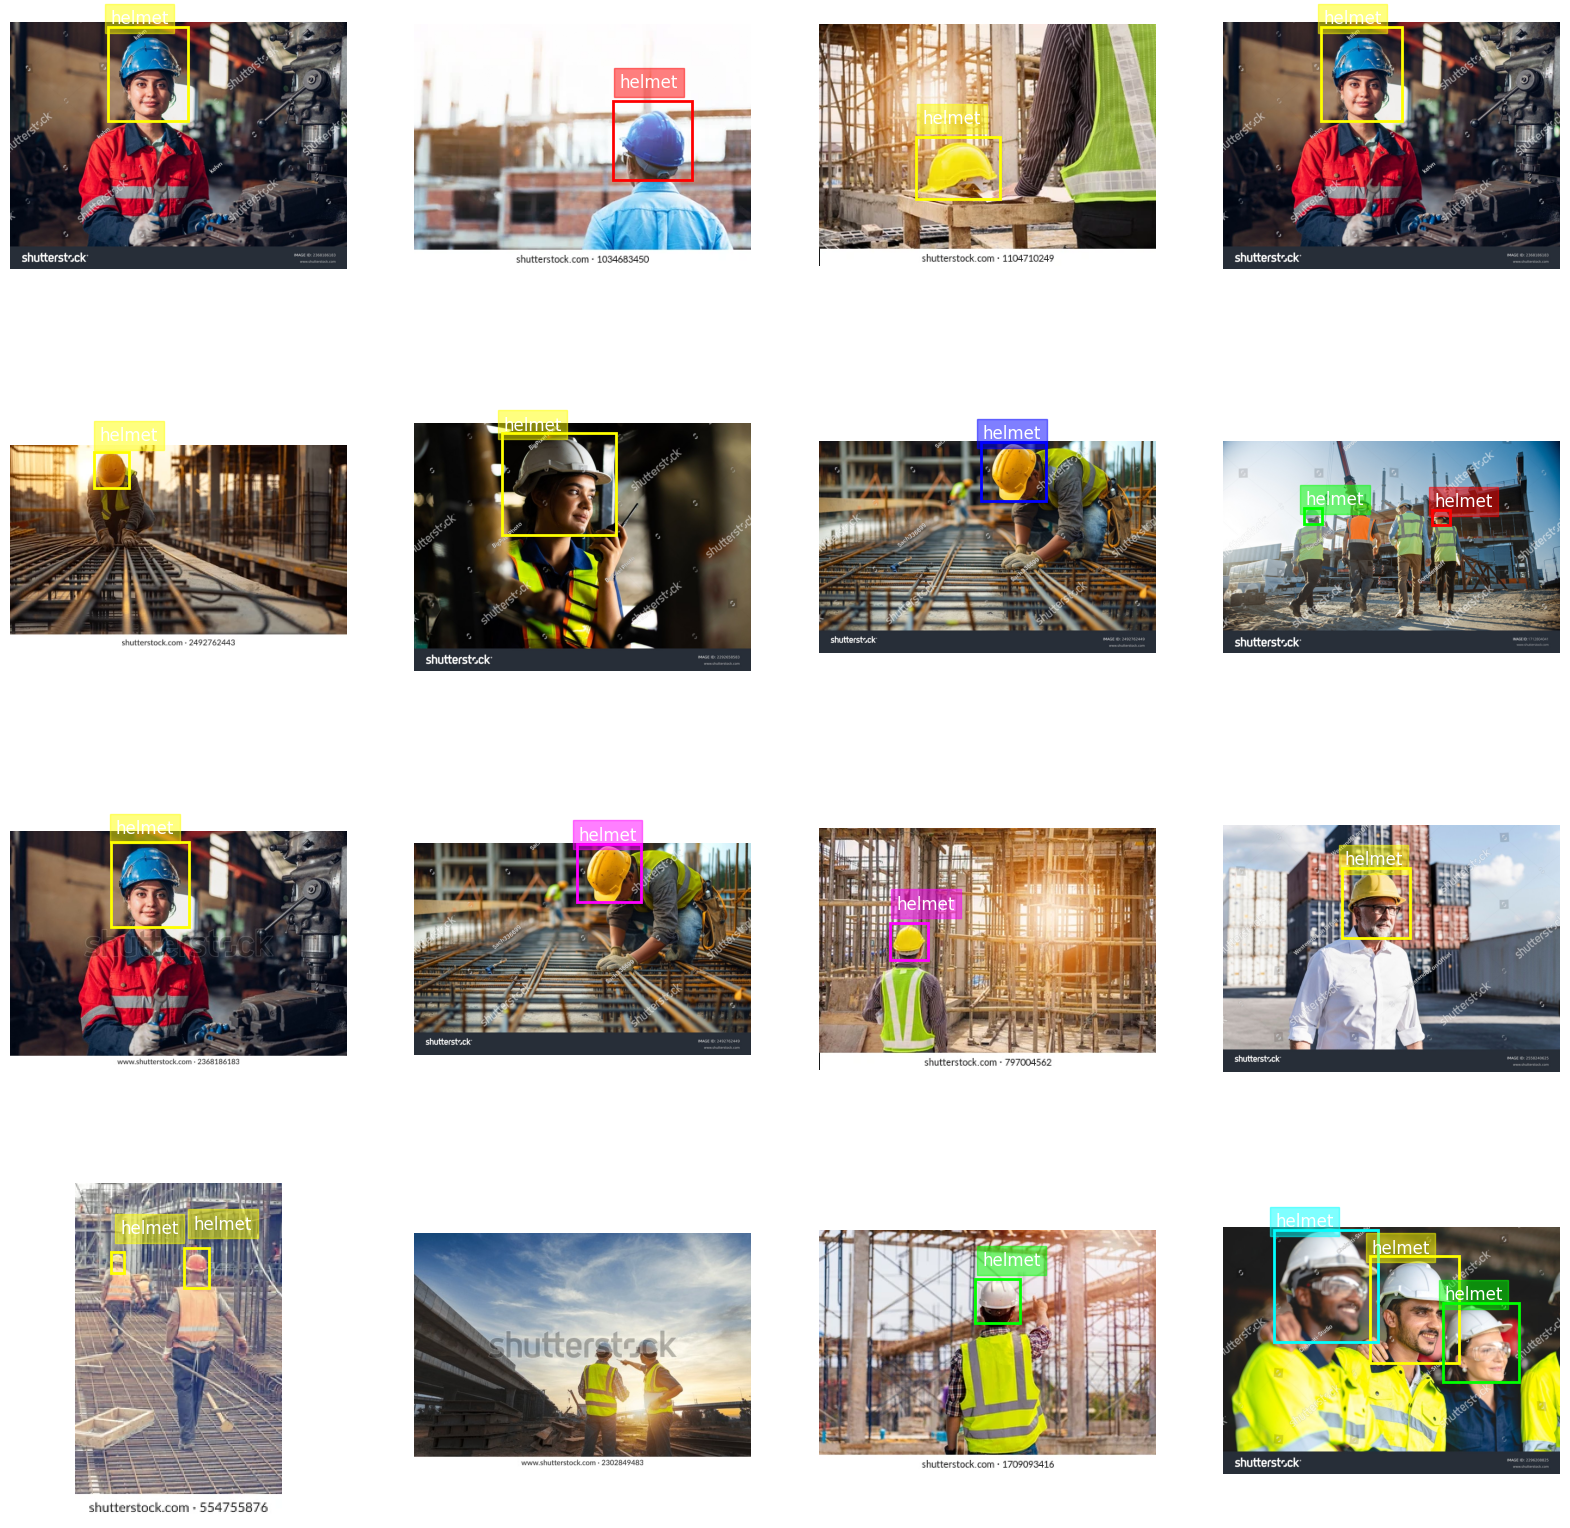

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image,ImageDraw
import random
import os
import torch
import torchvision
from torchvision.transforms import transforms


# Step 1: Recreate the model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_model(num_classes=4, size=640)

model.load_state_dict(torch.load("hard_hat_object_detection.pth",map_location=torch.device('cpu')))
# Assuming `model` and `test_data_loader` are already defined
model.eval()  # Set the model to evaluation mode
model.to(device)  # Ensure the model is on the correct device

# Create the plot
fig, ax = plt.subplots(4, 4, figsize=(20,20))
ax = ax.ravel()

transform = transforms.ToTensor()

test_dir = "test/"
test_list_file = os.listdir(test_dir)
# font = ImageFont.truetype("arial.ttf", 28)

class_names = ['bg', 'head', 'helmet', 'person']
color_sample = ['c','m','y']

for idx in range(16):
    # Prepare the image
    img_path = os.path.join(test_dir,random.choice(test_list_file))
    image = Image.open(img_path)
    image = transform(image)
    image_tensor = image.unsqueeze(0).to(device)  # Add a batch dimension

    # Get predictions
    with torch.no_grad():
        prediction = model(image_tensor)[0]  # Get the first image's predictions

    # print(prediction)

    # Convert image to numpy for visualization
    image_np = image.cpu().permute(1, 2, 0).numpy()  # Convert (C, H, W) -> (H, W, C)

    # Extract predictions
    boxes = prediction["boxes"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()

    ax[idx].imshow(image_np)
    ax[idx].axis('off')  # Hide axes

    img = Image.open(img_path)
    colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0), (0, 1, 1), (1, 1, 0), (0, 1, 0)]

    # Add bounding boxes to the image
    for box, label, score in zip(boxes, labels, scores):
        color = random.choice(colors)
        if score >= 0.8:
            xmin, ymin, xmax, ymax = box
            width, height = xmax - xmin, ymax - ymin
            rect = patches.Rectangle(
                (xmin, ymin),
                width,
                height,
                linewidth=2,
                edgecolor=color,
                facecolor="none",
            )
            ax[idx].add_patch(rect)
            ax[idx].text(
                xmin + 8,
                ymin - 16,
                f"{class_names[label]}",
                color='w',
                fontsize=12,
                bbox=dict(facecolor=color, alpha=0.5, edgecolor=color),
            )
            
    # Save only the individual subplot
    extent = ax[idx].get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f"img/subplot_001vdd{idx}.png", bbox_inches=extent, dpi=300)


# Display the image with bounding boxes
plt.show()